In [22]:
import json
from collections import Counter
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib import offsetbox
import pandas as pd
import numpy as np

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

In [23]:
with open('/home/meeka/Desktop/NU/453/assn3/json_texts_labels.json', 'r') as read_file:
    corpus_wLabels=json.load(read_file)
    
with open('/home/meeka/Desktop/NU/453/assn3/json_texts_orig.json', 'r') as read_file:
    corpus_wTitles=json.load(read_file)
    
vocab_dir='/home/meeka/Desktop/NU/453/assn2/vocab.txt'
file=open(vocab_dir, 'r')
vocab=file.read()
file.close()
print('Number of documents in corpus: ', len(corpus_wLabels))

Number of documents in corpus:  546


Following sections derived from:
https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [68]:
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer

corp_text=list(corpus_wLabels.keys())
labels=list(corpus_wLabels.values())
titles=list(corpus_wTitles.keys())
X_corp=[]

le = LabelEncoder()
y=le.fit_transform(labels)

category_to_id=dict(zip(labels,y))
id_to_category = dict(zip(y,labels))


df=pd.DataFrame(zip(labels,y, titles, corp_text), columns=['category', 'category_id', 'titles', 'text'])
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')


for text in corp_text:
    tokens=text.split()
    tokens=[w for w in tokens if w in vocab]
    wtokens=' '.join(tokens)
    X_corp.append(wtokens)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(X_corp).toarray()
features.shape

N=2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, y == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("'{}':".format(Product.upper()))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

'ETHICS':
  . Most correlated unigrams:
. morality
. moral
  . Most correlated bigrams:
. moral properties
. moral judgments
'LANGUAGE':
  . Most correlated unigrams:
. propositions
. proposition
  . Most correlated bigrams:
. propositions expressed
. private language
'LOGIC':
  . Most correlated unigrams:
. logic
. logics
  . Most correlated bigrams:
. logical consequence
. logical constants
'MATHEMATICS':
  . Most correlated unigrams:
. brouwer
. mathematics
  . Most correlated bigrams:
. set theory
. philosophy mathematics
'MIND':
  . Most correlated unigrams:
. cognitive
. mental
  . Most correlated bigrams:
. cognitive science
. mental states
'PHENOMENOLOGY':
  . Most correlated unigrams:
. phenomenal
. experiences
  . Most correlated bigrams:
. deflationary theory
. phenomenal character


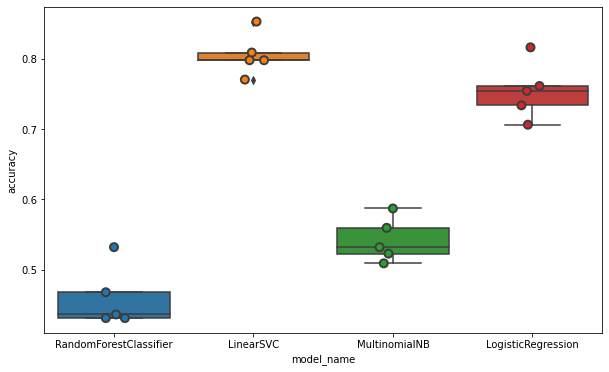

model_name
LinearSVC                 0.805855
LogisticRegression        0.754579
MultinomialNB             0.542185
RandomForestClassifier    0.459750
Name: accuracy, dtype: float64


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import seaborn as sns

features = tfidf.fit_transform(X_corp).toarray()
labels=y

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(), MultinomialNB(), LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

plt.figure(figsize=(10,6))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()
print(cv_df.groupby('model_name').accuracy.mean())

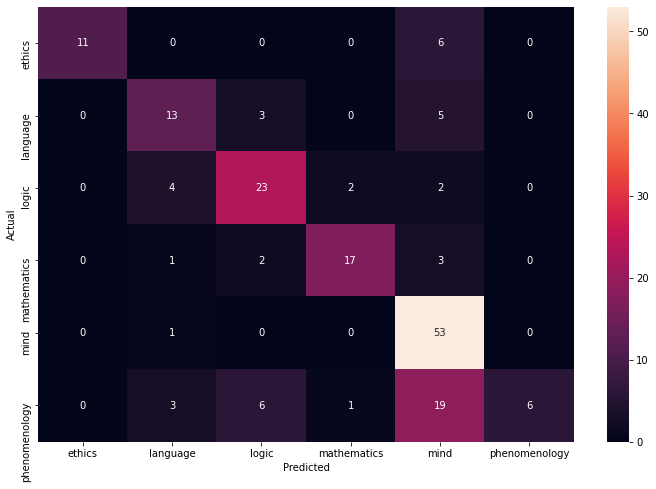

               precision    recall  f1-score   support

         mind       1.00      0.65      0.79        17
phenomenology       0.59      0.62      0.60        21
       ethics       0.68      0.74      0.71        31
        logic       0.85      0.74      0.79        23
  mathematics       0.60      0.98      0.75        54
     language       1.00      0.17      0.29        35

     accuracy                           0.68       181
    macro avg       0.79      0.65      0.65       181
 weighted avg       0.76      0.68      0.64       181

None


In [70]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(print(metrics.classification_report(y_test, y_pred, target_names=df['category'].unique())))

In [71]:
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 5:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 'titles']])
            print('')

'phenomenology' predicted as 'logic' : 6 examples.


,category,titles
436,phenomenology,Rudolf Carnap_2 Toward the Aufbau.txt
46,phenomenology,Carl Hempel_4 Scientific Explanations .txt
276,phenomenology,Modal Logic_6 Possible Worlds Semantics.txt
400,phenomenology,Logicism and Neologicism_5 Modal NeoLogicism.txt
533,phenomenology,Necessary and Sufficient Conditions_2 The Stan...
154,phenomenology,Tarskis Truth Definitions_3 The 1956 definitio...



'ethics' predicted as 'mind' : 6 examples.


,category,titles
503,ethics,Immanuel Kant_5 Morality and freedom.txt
242,ethics,Virtue Ethics_4 Future Directions.txt
108,ethics,Thomas Reid_6 Moral Philosophy.txt
202,ethics,Moral Psychology Empirical Approaches_6 Moral...
101,ethics,Moral Psychology Empirical Approaches_3 Moral...
437,ethics,Alfred North Whitehead_7 Religion.txt



'language' predicted as 'mind' : 5 examples.


,category,titles
406,language,Reference_1 Introduction.txt
172,language,Skepticism_3 The Argument for Cartesian Skepti...
293,language,Otto Neurath_2 From economic theory to scienti...
354,language,Private Language_3 The Private Language Argume...
272,language,Religious Language_2 The Content of Religious ...



'phenomenology' predicted as 'mind' : 19 examples.


,category,titles
137,phenomenology,Alfred North Whitehead_6 Metaphysics.txt
142,phenomenology,Abstract Objects_3 The Way of Negation.txt
15,phenomenology,Abstract Objects_4 The Way of Example.txt
185,phenomenology,Abstract Objects_2 Historical Remarks.txt
438,phenomenology,States of Affairs_4 States of Affairs as Compl...
540,phenomenology,Phenomenal Intentionality_5 Cognitive phenomen...
348,phenomenology,The Contents of Perception_9 Directions for Fu...
401,phenomenology,The Problem of Perception_2 The Problem of Per...
71,phenomenology,Representational Theories of Consciousness_3 A...
190,phenomenology,The Contents of Perception_8 Theories of Inten...


In [65]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'ethics':
  . Top unigrams:
       . moral
       . ethics
  . Top bigrams:
       . moral judgments
       . moral properties
# 'language':
  . Top unigrams:
       . proposition
       . propositions
  . Top bigrams:
       . proposition true
       . natural language
# 'logic':
  . Top unigrams:
       . logic
       . logical
  . Top bigrams:
       . logical constants
       . logical consequence
# 'mathematics':
  . Top unigrams:
       . mathematics
       . mathematical
  . Top bigrams:
       . set theory
       . philosophy mathematics
# 'mind':
  . Top unigrams:
       . mental
       . knowledge
  . Top bigrams:
       . mental states
       . mental state
# 'phenomenology':
  . Top unigrams:
       . experience
       . experiences
  . Top bigrams:
       . deflationary theory
       . abstract objects


In [86]:
corp_text=list(corpus_wLabels.keys())
labels=list(corpus_wLabels.values())
X_corp=[]
corp_words=Counter()

le = LabelEncoder()
y=le.fit_transform(labels)

stopwords=['however','whether','even','may','given','one','also','way', 'every','simply','terms','kind','claim',
           'would','two','first','seems','seem','false','might','without','simple', 'like','see','view','example']

for text in corp_text:
    tokens=text.split()
    tokens=[w for w in tokens if w in vocab]
    tokens=[w for w in tokens if not w in stopwords]
    porter=PorterStemmer()
    tokens=[porter.stem(word) for word in tokens]
    corp_words.update(tokens)
    wtokens=' '.join(tokens)
    X_corp.append(wtokens)

print('Full corpus filtered vocab size after stemming: %d' % len(corp_words))

Full corpus filtered vocab size: 2316


Explained variance of the SVD step: 19%


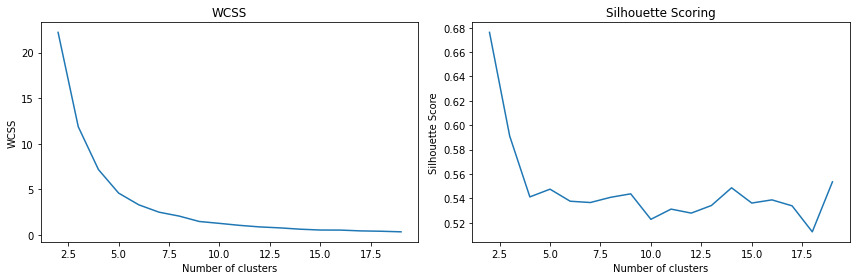


Homogeneity: 0.326
Completeness: 0.318
V-measure: 0.322
Adjusted Rand-Index: 0.208
Silhouette Coefficient: 0.542

Cluster 0: theori experi proposit content object state logic properti mental differ
Cluster 1: proposit logic theori truth set true relat number express object
Cluster 2: experi content theori state mental object properti represent belief differ
Cluster 3: experi theori content state mental object properti differ represent belief
Cluster 4: proposit logic set theori truth true number relat express sentenc
Cluster 5: proposit logic theori object truth true relat set use concept


In [108]:
#Count Vectorizer Clusters

CV=CountVectorizer()
X_cv=CV.fit_transform(X_corp)

svd=TruncatedSVD()
normalizer=Normalizer(copy=False)
lsa=make_pipeline(svd,normalizer)
X=lsa.fit_transform(X_cv)
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

wcss=[]
ss=[]
for i in range(2,20):
    km=KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1)
    km.fit(X)
    ss.append(metrics.silhouette_score(X, km.labels_))
    wcss.append(km.inertia_)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))   
ax1.plot(range(2,20),wcss)
ax1.set_title('WCSS')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS')
ax2.plot(range(2,20),ss)
ax2.set_title('Silhouette Scoring')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

n_clust=6
km=KMeans(n_clusters=n_clust, init='k-means++', max_iter=100, n_init=1)
km.fit(X)

print()
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, km.labels_))
print()

CV_Clusters=km.labels_

original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = CV.get_feature_names()

for i in range(n_clust):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
        kterms.append(terms[ind])
    print()

Computing Count Vectorizer t-SNE embedding


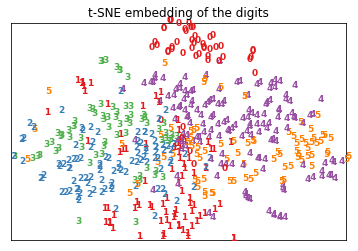

In [112]:
#T-SNE manifold

def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),color=plt.cm.Set1(y[i] / 10.), fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]])
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                continue
            shown_images = np.r_[shown_images, [X[i]]]
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

print("Computing Count Vectorizer t-SNE embedding")
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_cv)
plot_embedding(X_tsne,"t-SNE embedding of Documents")

In [60]:
Cluster_DF = pd.DataFrame(zip(labels,km.labels_), columns=['label','cluster'])
Cluster_DF['vals']=1
table=pd.pivot_table(Cluster_DF, values='vals', index=['label'], columns=['cluster'], aggfunc=np.sum)
table

cluster,0,1,2,3,4,5
label,,,,,,
ethics,NaN,21.0,4.0,25.0,NaN,NaN
language,24.0,NaN,19.0,5.0,NaN,34.0
logic,60.0,NaN,5.0,1.0,NaN,35.0
mathematics,33.0,NaN,15.0,1.0,NaN,23.0
mind,NaN,71.0,9.0,46.0,29.0,4.0
ontology,2.0,13.0,15.0,11.0,29.0,12.0


Explained variance of the SVD step: 4%


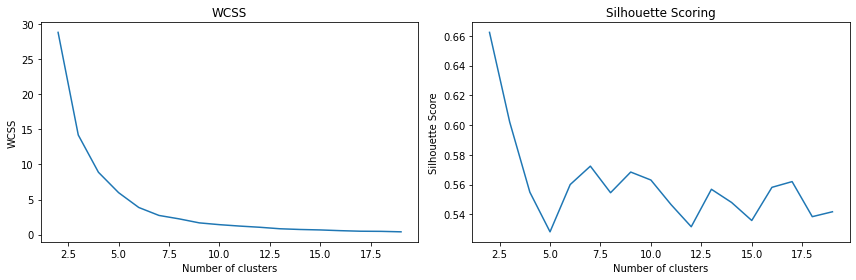


Homogeneity: 0.380
Completeness: 0.372
V-measure: 0.376
Adjusted Rand-Index: 0.235
Silhouette Coefficient: 0.561

Cluster 0: logic proposit theori sentenc mathemat object set properti moral truth
Cluster 1: logic proposit set mathemat sentenc axiom theori number secondord russel
Cluster 2: experi mental content moral state represent properti belief cognit object
Cluster 3: logic proposit mathemat set theori sentenc number truth axiom russel
Cluster 4: experi mental content moral state represent cognit phenomen belief properti
Cluster 5: experi mental content moral proposit state logic theori properti represent


In [106]:
#TFIDF Clusters

TFIDF_CV=TfidfVectorizer()
X_tfidf=TFIDF_CV.fit_transform(X_corp)

svd=TruncatedSVD()
normalizer=Normalizer(copy=False)
lsa=make_pipeline(svd,normalizer)
X=lsa.fit_transform(X_tfidf)
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

wcss=[]
ss=[]
for i in range(2,20):
    km=KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1)
    km.fit(X)
    ss.append(metrics.silhouette_score(X, km.labels_))
    wcss.append(km.inertia_)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))   
ax1.plot(range(2,20),wcss)
ax1.set_title('WCSS')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS')
ax2.plot(range(2,20),ss)
ax2.set_title('Silhouette Scoring')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette Score')
plt.tight_layout()
plt.show()


n_clust=6
km=KMeans(n_clusters=n_clust, init='k-means++', max_iter=100, n_init=1)
km.fit(X)

print()
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, km.labels_))
print()

TFIDF_Clusters=km.labels_

original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = TFIDF_CV.get_feature_names()

for i in range(n_clust):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
        kterms.append(terms[ind])
    print()

Computing Count Vectorizer t-SNE embedding


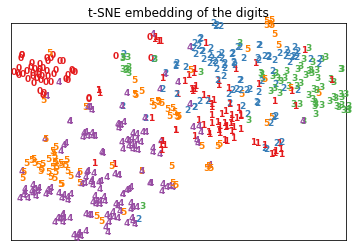

In [113]:
#T-SNE manifold

def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),color=plt.cm.Set1(y[i] / 10.), fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]])
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                continue
            shown_images = np.r_[shown_images, [X[i]]]
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

print("Computing Count Vectorizer t-SNE embedding")
tsne = TSNE(n_components=2,)
X_tsne = tsne.fit_transform(X_tfidf)
plot_embedding(X_tsne,"t-SNE embedding of Documents")

In [62]:
Cluster_DF = pd.DataFrame(zip(labels,km.labels_), columns=['label','cluster'])
Cluster_DF['vals']=1
table=pd.pivot_table(Cluster_DF, values='vals', index=['label'], columns=['cluster'], aggfunc=np.sum)
table

cluster,0,1,2,3,4,5
label,,,,,,
ethics,35.0,NaN,1.0,NaN,1.0,13.0
language,NaN,35.0,NaN,1.0,36.0,10.0
logic,NaN,60.0,NaN,29.0,11.0,1.0
mathematics,NaN,29.0,NaN,33.0,10.0,NaN
mind,76.0,NaN,29.0,NaN,9.0,45.0
ontology,10.0,7.0,31.0,1.0,23.0,10.0


(546, 50)
Explained variance of the SVD step: 8%


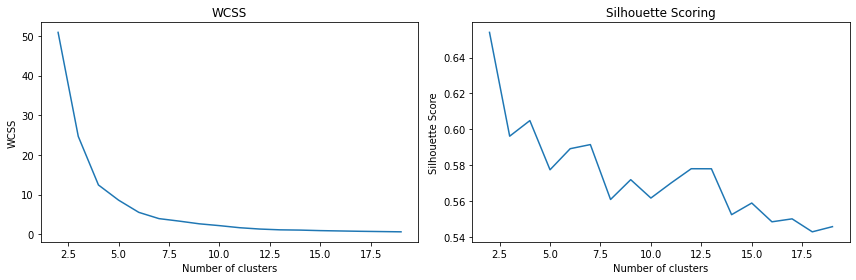


Homogeneity: 0.309
Completeness: 0.300
V-measure: 0.304
Adjusted Rand-Index: 0.205
Silhouette Coefficient: 0.570



In [63]:
#Analysis 3: Doc2Vec

def tokenize_docs(X):
    word_tokens=[]
    for doc in X:
        tokens=doc.split()
        word_tokens.append(tokens)
    return word_tokens
    
X_train_tokens=tokenize_docs(X_corp)

#50 Dim
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_train_tokens)]
model_50dim = Doc2Vec(documents, vector_size=50, window=4, min_count=2, epochs=50)
model_50dim.train(documents, total_examples = model_50dim.corpus_count, epochs = model_50dim.epochs)

#Vectorize Training Set:
doc2vec_50_vectors = np.zeros((len(X_train_tokens), 50)) 
for i in range(0, len(X_train_tokens)):
    doc2vec_50_vectors[i,] = model_50dim.infer_vector(X_train_tokens[i]).transpose()
print(doc2vec_50_vectors.shape)


svd=TruncatedSVD()
normalizer=Normalizer(copy=False)
lsa=make_pipeline(svd,normalizer)
X=lsa.fit_transform(doc2vec_50_vectors)
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

wcss=[]
ss=[]
for i in range(2,20):
    km=KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1)
    km.fit(X)
    ss.append(metrics.silhouette_score(X, km.labels_))
    wcss.append(km.inertia_)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))   
ax1.plot(range(2,20),wcss)
ax1.set_title('WCSS')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS')
ax2.plot(range(2,20),ss)
ax2.set_title('Silhouette Scoring')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

n_clust=6
km=KMeans(n_clusters=n_clust, init='k-means++', max_iter=100, n_init=1)
km.fit(X)

print()
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, km.labels_))
print()

Doc2Vec_Clusters=km.labels_

Computing Count Vectorizer t-SNE embedding


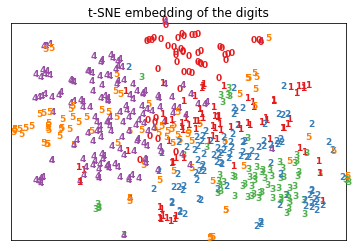

In [114]:
#Doc2Vec T-SNE manifold

def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),color=plt.cm.Set1(y[i] / 10.), fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]])
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                continue
            shown_images = np.r_[shown_images, [X[i]]]
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


print("Computing Count Vectorizer t-SNE embedding")
tsne = TSNE(n_components=2,)
X_tsne = tsne.fit_transform(doc2vec_50_vectors)
plot_embedding(X_tsne,"t-SNE embedding of Documents")

# Summarize Clusters

In [115]:
titles=list(corpus_wTitles.keys())
clustersets=zip(titles, labels,CV_Clusters,TFIDF_Clusters,Doc2Vec_Clusters)
Full_Clusters=pd.DataFrame(clustersets, columns=['titles','labels','CountVec', 'TFIDF', 'Doc2Vec'])
Full_Clusters['counts']=1
Full_Clusters.to_csv('cluster_groups.csv')

In [119]:
Clusters_Crosstab=pd.pivot_table(Full_Clusters, values='counts', index=['labels'], columns=['CountVec'], aggfunc=np.sum)
print(Clusters_Crosstab/Clusters_Crosstab.sum())
print()
Clusters_Crosstab=pd.pivot_table(Full_Clusters, values='counts', index=['labels'], columns=['TFIDF'], aggfunc=np.sum)
print(Clusters_Crosstab/Clusters_Crosstab.sum())
print()
Clusters_Crosstab=pd.pivot_table(Full_Clusters, values='counts', index=['labels'], columns=['Doc2Vec'], aggfunc=np.sum)
print(Clusters_Crosstab/Clusters_Crosstab.sum())

CountVec            0         1         2         3         4         5
labels                                                                 
ethics       0.250000       NaN       NaN  0.212389       NaN  0.044776
language     0.119565  0.300971       NaN       NaN  0.196262  0.283582
logic        0.032609  0.378641       NaN       NaN  0.504673  0.074627
mathematics  0.032609  0.223301       NaN       NaN  0.280374  0.238806
mind         0.445652  0.019417  0.515625  0.672566       NaN  0.104478
ontology     0.119565  0.077670  0.484375  0.115044  0.018692  0.253731

TFIDF               0         1         2         3         4         5
labels                                                                 
ethics       0.024390       NaN  0.297297       NaN  0.016393  0.170732
language     0.402439  0.023810       NaN  0.325397       NaN  0.073171
logic        0.085366  0.488095       NaN  0.412698       NaN  0.012195
mathematics  0.097561  0.464286       NaN  0.198413       NaN  

In [78]:
Clusters_Crosstab=pd.pivot_table(Full_Clusters, values='counts', index=['CountVec'], columns=['TFIDF'], aggfunc=np.sum)
print(Clusters_Crosstab)
print()
Clusters_Crosstab=pd.pivot_table(Full_Clusters, values='counts', index=['CountVec'], columns=['Doc2Vec'], aggfunc=np.sum)
print(Clusters_Crosstab)
print()
Clusters_Crosstab=pd.pivot_table(Full_Clusters, values='counts', index=['TFIDF'], columns=['Doc2Vec'], aggfunc=np.sum)
print(Clusters_Crosstab)

# Clusters_Crosstab=pd.pivot_table(Full_Clusters, values='counts', index=['CountVec','TFIDF','Doc2Vec'], columns=['labels'], aggfunc=np.sum)
# Clusters_Crosstab

TFIDF        0     1     2     3     4     5
CountVec                                    
0          NaN  61.0   NaN  56.0   2.0   NaN
1         91.0   NaN   9.0   NaN   NaN   5.0
2          NaN   7.0   NaN   NaN  50.0  10.0
3         24.0   NaN   NaN   NaN   3.0  62.0
4          6.0   NaN  52.0   NaN   NaN   NaN
5          NaN  63.0   NaN   8.0  35.0   2.0

Doc2Vec      0     1     2     3     4     5
CountVec                                    
0         10.0   NaN  72.0   NaN  37.0   NaN
1          2.0  39.0   NaN  19.0   1.0  44.0
2         25.0   3.0   5.0  14.0  20.0   NaN
3         16.0  21.0   NaN  44.0   6.0   2.0
4          NaN  11.0   NaN   1.0   NaN  46.0
5         27.0   NaN  32.0   5.0  44.0   NaN

Doc2Vec     0     1     2     3     4     5
TFIDF                                      
0         2.0  45.0   NaN  31.0   NaN  43.0
1        16.0   NaN  49.0   NaN  66.0   NaN
2         NaN  11.0   NaN   2.0   NaN  48.0
3         1.0   NaN  58.0   NaN   5.0   NaN
4        47.0 

# Heirarchical Clustering

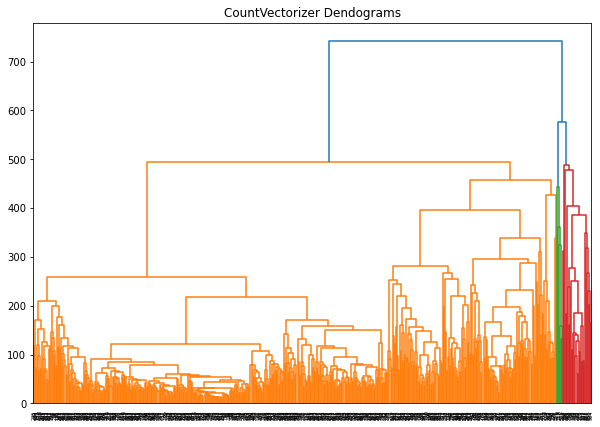

In [154]:
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

X=X_cv.toarray() 
plt.figure(figsize=(10, 8))
plt.title("CountVectorizer Dendograms")
dend = shc.dendrogram(shc.linkage(X, method='ward'))

In [155]:
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
Agglom_CV=cluster.fit_predict(X)

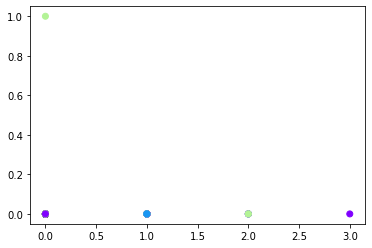

In [157]:
plt.figure(figsize=(6, 4))
plt.scatter(X[:,0], X[:,1], c=cluster.labels_, cmap='rainbow')

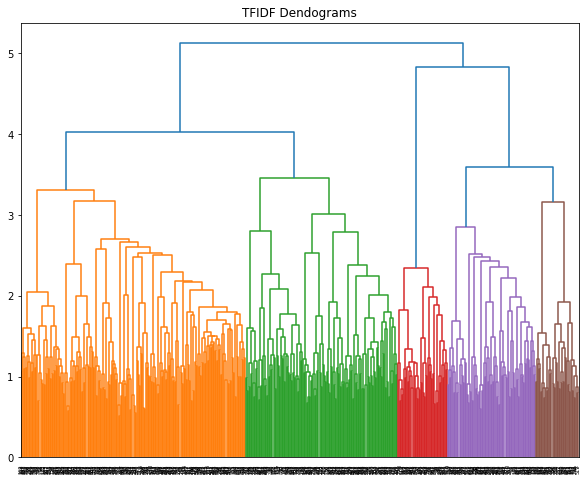

In [159]:
X=X_tfidf.toarray() 
plt.figure(figsize=(10, 8))
plt.title("TFIDF Dendograms")
dend = shc.dendrogram(shc.linkage(X, method='ward'))

In [160]:
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
Agglom_TFIDF=cluster.fit_predict(X)

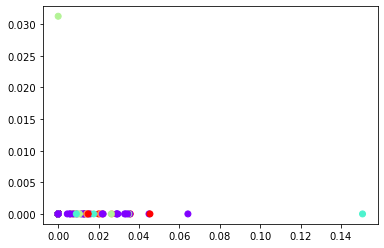

In [161]:
plt.figure(figsize=(6, 4))
plt.scatter(X[:,0], X[:,1], c=cluster.labels_, cmap='rainbow')

In [162]:
agglom=zip(titles,labels, Agglom_CV, Agglom_TFIDF)
Agglom_Clusters=pd.DataFrame(agglom, columns=['titles','labels','CV', 'TFIDF'])
Agglom_Clusters['counts']=1
Agglom_Clust=pd.pivot_table(Agglom_Clusters, values='counts', index=['labels'], columns=['CV'], aggfunc=np.sum)
print(Agglom_Clust/Agglom_Clust.sum())
print()
Agglom_Clust=pd.pivot_table(Agglom_Clusters, values='counts', index=['labels'], columns=['TFIDF'], aggfunc=np.sum)
print(Agglom_Clust/Agglom_Clust.sum())

CV                  0     1         2         3    4    5
labels                                                   
ethics       0.072727   NaN       NaN  0.109510  NaN  NaN
language     0.206061   NaN       NaN  0.132565  1.0  NaN
logic        0.030303  0.76       NaN  0.221902  NaN  NaN
mathematics  0.084848  0.08       NaN  0.158501  NaN  1.0
mind         0.430303   NaN  0.166667  0.250720  NaN  NaN
ontology     0.175758  0.16  0.833333  0.126801  NaN  NaN

TFIDF               0         1         2         3         4         5
labels                                                                 
ethics       0.022727       NaN       NaN       NaN       NaN  0.918367
language     0.309091       NaN  0.160714  0.043011  0.011628       NaN
logic        0.136364       NaN  0.750000  0.301075  0.011628       NaN
mathematics  0.077273       NaN  0.017857  0.580645       NaN       NaN
mind         0.286364  0.404762  0.017857  0.021505  0.860465  0.040816
ontology     0.168182  0.595238

In [163]:
len(Agglom_TFIDF)

546

546

In [ ]:
#Maybe Useful, set distributions and breakups

clusters=list(keyterms.keys())
keywords=list(keyterms.values())

c_subsets=[]

for c in clusters:
    unique_set=[]
    otreset=Counter()
    for item in list(zip(clusters,keywords)):
        if item[0]==c:
            setwords=item[1]
            print(c)
            print(setwords)
        else:
            for word in item[1]:
                otreset.update([word])
    unique_set=[word for word in setwords if not word in list(otreset)]
    print(unique_set)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics

vectorizer = CountVectorizer()
X_CV = vectorizer.fit_transform(X_corp)

num_clust=20
km=KMeans(n_clusters=num_clust, max_iter=100)
km.fit(X_CV)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, km.labels_))

In [ ]:
print("Top terms per cluster")
order_centroids=km.cluster_centers_.argsort()[:,::-1]
terms=vectorizer.get_feature_names()
for i in range(num_clust):
    print("Cluster %d:" %i, end='')
    for ind in order_centroids[i,:20]:
        print(' %s' % terms[ind], end='')
    print()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
TFIDF_CV=TfidfVectorizer(max_features=200)
X_tfidf=TFIDF_CV.fit_transform(X)